In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1]:
from ontological_processor import OntologicalProcessor
from preprocess_transcription import Preprocessor
from callsign_matcher import CallsignMatcher

# Loading Data

In [3]:
transcription_file_loc = '../sample_transcriptions/2021-11-02.txt'
proc = Preprocessor(transcription_file_loc)

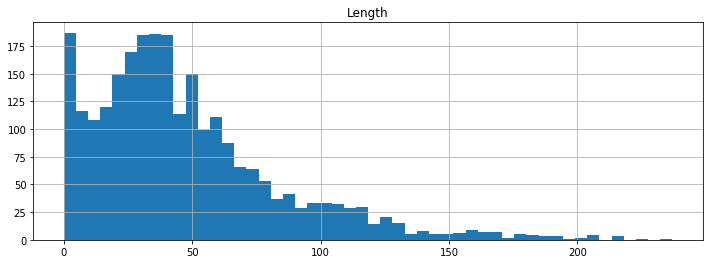

In [4]:
proc.plot_length_distribution()

In [5]:
df = proc.get_transcriptions(15)

In [6]:
df.to_csv('test.csv', index=False)

# Processing

In [7]:
op = OntologicalProcessor()

In [8]:
df['altitude'] = df['Transcriptions'].apply(op.find_alt)
df['heading'] = df['Transcriptions'].apply(op.find_turn)
df['speed'] = df['Transcriptions'].apply(op.find_speed)
df['contact'] = df['Transcriptions'].apply(op.find_contact)
df['clearance'] = df['Transcriptions'].apply(op.find_clearance)
df['callsign'] = df['Transcriptions'].apply(op.find_callsign)



C:\Users\Michael.Lutz22\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Michael.Lutz22\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Michael.Lutz22\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on

# Callsign Matcher
Accounting for incomplete or nearly-complete callsign utterances

In [22]:
flight_data_link = '../flight_data/11-2-21.csv'
cm = CallsignMatcher(flight_data_link)

In [24]:
df = pd.read_csv(flight_data_link)

In [76]:
def find_match(callsign, threshold=None):
        # calculate levenshtein distance for string on all of the available callsigns
        l_distances = df['callsign'].apply(lambda x: iterative_levenshtein(callsign, x))
        return df.iloc[l_distances.idxmin()]

In [83]:
find_match('AAL2854')

icao24                    ad3d4e
callsign                AAL2854 
origin_country     United States
time_position         1635884356
last_contact          1635884356
longitude               -96.0856
latitude                  32.977
baro_altitude            6682.74
on_ground                  False
velocity                     218
heading                     68.4
vertical_rate              10.08
sensors                      NaN
geo_altitude             6903.72
squawk                      2314
spi                        False
position_source                0
fetch_time            1635884357
Name: 7, dtype: object

In [9]:
df.to_csv('test.csv', index=False)

In [11]:

df.callsign.value_counts

NA          1041
AAL1519       16
AAL1892       13
AAL356        12
AAL221        12
            ... 
ENY4065        1
AAL1119        1
AAL65670       1
SKW4582        1
ENY3922        1
Name: callsign, Length: 456, dtype: int64

In [10]:
df['heading'].value_counts()

NA            1344
Missing ST     368
330             75
020             60
090             35
              ... 
174              1
656              1
767              1
426              1
520              1
Name: heading, Length: 80, dtype: int64

In [8]:
string = df['Transcriptions'].iloc[2]

In [74]:
def iterative_levenshtein(s, t):
    """ 
        iterative_levenshtein(s, t) -> ldist
        ldist is the Levenshtein distance between the strings 
        s and t.
        For all i and j, dist[i,j] will contain the Levenshtein 
        distance between the first i characters of s and the 
        first j characters of t
    """

    if not type(t) == str:
        return 9999

    s = s.strip()
    t = t.strip()

    if t == s:
        return 0

    rows = len(s)+1
    cols = len(t)+1
    dist = [[0 for x in range(cols)] for x in range(rows)]

    # source prefixes can be transformed into empty strings 
    # by deletions:
    for i in range(1, rows):
        dist[i][0] = i

    # target prefixes can be created from an empty source string
    # by inserting the characters
    for i in range(1, cols):
        dist[0][i] = i
        
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0
            else:
                cost = 1
            dist[row][col] = min(dist[row-1][col] + 1,      # deletion
                                 dist[row][col-1] + 1,      # insertion
                                 dist[row-1][col-1] + cost) # substitution

    
 
    return dist[row][col]

In [20]:
import re

In [47]:
def process_callsign(string):
    string = string.lower()
    #lower 
    """
        process_callsign(string) -> callsign
        callsign is the callsign of the aircraft in the string
    """
    callsign = string.split(' ')
    callsign_map = {"american":"AAL", "november":"N", "jetblue":"JBU",
                    "envoy":"ENY", "skywest":"SKW", "skylan":"SKA",
                    "cessna":"N", "sioux":"UND", "delta":"DAL",
                    "jet":"JSX", "fedex":"FDX", "flexjet":"LXJ"} 
    for key in callsign_map.keys():
        abbreviated_callsign = callsign[0].replace(key, callsign_map[key])
        if abbreviated_callsign != callsign[0]:
            return abbreviated_callsign+callsign[1]
    return 'N'+callsign[1]

In [46]:
df['callsign']

'FDXd335'

In [15]:
iterative_levenshtein('abc', 'abcd')

1

In [19]:
df['callsign'].apply(lambda x: x[:3]).value_counts()

NA     825
ame    770
env    370
sky    129
ces     11
sio      6
fro      3
Name: callsign, dtype: int64

# Test Code (delete later)

In [22]:
string_1 = '1808 REDUCE SPEED TO 1 9 0'

while (string_1 != re.sub(r'\d+\s+\d+', change, string_1)):
    string_1 = re.sub(r'\d+\s+\d+', change, string_1)

# regex expression for one digit followed by one space followed by one digit

In [17]:
#   iterative_levenshtein(s, t) -> ldist
#   ldist is the Levenshtein distance between the strings 
#   s and t.
#   For all i and j, dist[i,j] will contain the Levenshtein 
#   distance between the first i characters of s and the 
#   first j characters of t

def iterative_levenshtein(s, t):
    

    rows = len(s)+1
    cols = len(t)+1
    dist = [[0 for x in range(cols)] for x in range(rows)]

    # source prefixes can be transformed into empty strings 
    # by deletions:
    for i in range(1, rows):
        dist[i][0] = i

    # target prefixes can be created from an empty source string
    # by inserting the characters
    for i in range(1, cols):
        dist[0][i] = i
        
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0
            else:
                cost = 1
            dist[row][col] = min(dist[row-1][col] + 1,      # deletion
                                 dist[row][col-1] + 1,      # insertion
                                 dist[row-1][col-1] + cost) # substitution    

    return dist[row][col]

2


In [19]:
iterative_levenshtein('test', '2')

4

In [53]:
find_alt(df['Transcriptions'].iloc[4])

7000

In [44]:
command = df['Transcriptions'].iloc[2]
print(find_alt(command))

AMERICAN 1583 MAINTAIN 180 KNOTS TO ZALPO CONTACT TOWER NOW 127.5 HAVE AH GOOD DAY
['american', '1583', 'maintain', '180', 'knots', 'to', 'zalpo', 'contact', 'tower', 'now', '127.5', 'have', 'ah', 'good', 'day']
[1]
[2]
None


In [75]:
df

,Time,Transcriptions,Length,altitude,turn
51,21-11-02 07:14:45.389,DELTA 1169 APPROACH GOOD MORNING 35 RIGHT,41,True,True
52,21-11-02 07:14:45.698,AMERICAN 1583 AH MILES FROM 3 MAINTAIN 3000 UN...,110,False,False
53,21-11-02 07:14:45.866,AMERICAN 1583 MAINTAIN 180 KNOTS TO ZALPO CONT...,82,False,False
54,21-11-02 07:14:46.199,AMERICAN 14 03 DESCEND AND MAINTAIN 7000,40,False,False
55,21-11-02 07:14:46.364,DELTA 1169 MAINTAIN 7000,24,False,False
56,21-11-02 07:14:46.599,CITATION 7MM HEADING 330 AND INTERCEPT THE LOC...,52,True,True
57,21-11-02 07:14:46.759,AMERICAN 14 03 REDUCE SPEED TO 1 9 0 HEADING 260,48,True,True
58,21-11-02 07:14:47.112,ENVOY 3746 APPROACH GOOD MORNING DESCEND VIA 7...,167,True,True
59,21-11-02 07:14:47.268,REGIONAL APPROACH AMERICAN 1374 OUT OF 6300 DE...,82,False,False
60,21-11-02 07:14:47.547,AMERICAN 1374 REGIONAL APPROACH GOOD MORNING 3...,52,True,True
